<h1 align='center'>Time-Series forecasting</h1> 

В данной работе я попробую предсказать количество посетителей сайта https://lacity.gov/, используя для этого различные модели. <br>
А также проанализирую сами данные на наличие различный аномалий

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sps
from scipy.stats import shapiro, norm, kstest
from scipy.stats import mannwhitneyu
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from catboost import CatBoostRegressor
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme(style='darkgrid')

In [4]:
%config IPCompleter.greedy=True

# Описание полей данных
<hr>
<ul>
    <li> Date - дата в формате yyyy/mm/dd    
    <li> Device Category - категория устройство с которого был произведен вход на сайт
    <li> Browser - браузер
    <li> Visitors - количество посетителей сайта
    <li> Sessions -  количество сессий
    <li> Bounce Rate -  процентное соотношение количества посетителей, покинувших сайт прямо со страницы входа или просмотревших не более одной страницы сайта
<ul/>

In [5]:
data = pd.read_csv('lacity.org-website-traffic.csv')
data.shape

(8348985, 6)

In [6]:
data.tail(5)

,Date,Device Category,Browser,# of Visitors,Sessions,Bounce Rate
8348980,2019-08-27T00:00:00.000,mobile,Chrome,199,318,50.0000
8348981,2019-08-27T00:00:00.000,mobile,Firefox,40,40,100.0000
8348982,2019-08-27T00:00:00.000,mobile,Safari,199,199,79.8995
8348983,2019-08-27T00:00:00.000,tablet,Amazon Silk,40,40,100.0000
8348984,2019-08-27T00:00:00.000,tablet,Chrome,40,40,100.0000


# Предобработка данных

In [7]:
data.rename(columns={'# of Visitors':'Visitors'}, inplace=True)

In [8]:
data.columns = data.columns.str.replace(' ','_')

<b> Видим, что пропущенные значения отсутствуют

In [9]:
data.isna().any()

Date               False
Device_Category    False
Browser            False
Visitors           False
Sessions           False
Bounce_Rate        False
dtype: bool

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8348985 entries, 0 to 8348984
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Date             object 
 1   Device_Category  object 
 2   Browser          object 
 3   Visitors         int64  
 4   Sessions         int64  
 5   Bounce_Rate      float64
dtypes: float64(1), int64(2), object(3)
memory usage: 382.2+ MB


In [11]:
data.Date = pd.to_datetime(data.Date, yearfirst=True)

<b> Добавим новые колонки для лучшей визуализации наших данных

In [12]:
data['Day'] = data.Date.dt.day
data['Day_of_year'] = data.Date.dt.day_of_year
data['Week'] = data.Date.dt.isocalendar().week
data['Month'] = data.Date.dt.month_name()
data['Year'] = data.Date.dt.year

In [13]:
data.describe()

,Visitors,Sessions,Bounce_Rate,Day,Day_of_year,Week,Year
count,8.348985e+06,8.348985e+06,8.348985e+06,8.348985e+06,8.348985e+06,8.348985e+06,8.348985e+06
mean,6.150075e+02,6.899815e+02,5.246254e+01,1.566720e+01,1.770286e+02,2.577327e+01,2.016133e+03
std,9.586180e+02,1.093220e+03,3.215602e+01,8.781977e+00,1.057347e+02,1.510684e+01,1.507790e+00
min,3.500000e+01,3.500000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.014000e+03
25%,4.000000e+01,7.000000e+01,3.333330e+01,8.000000e+00,8.400000e+01,1.300000e+01,2.015000e+03
50%,2.190000e+02,2.370000e+02,5.000000e+01,1.600000e+01,1.750000e+02,2.500000e+01,2.016000e+03
75%,8.340000e+02,9.220000e+02,7.640620e+01,2.300000e+01,2.680000e+02,3.900000e+01,2.017000e+03
max,3.436500e+04,4.617200e+04,1.000000e+02,3.100000e+01,3.660000e+02,5.300000e+01,2.019000e+03


<b> Здесь мы можем увидить, за какой год были получены неполные данные, а именно за 2019

In [14]:
data.groupby(['Year'], as_index=False).agg({'Day_of_year': 'nunique', 'Date': ['min', 'max'], 'Month': 'nunique'})

Year Day_of_year       Date              Month
            nunique        min        max nunique
0  2014         365 2014-01-01 2014-12-31      12
1  2015         365 2015-01-01 2015-12-31      12
2  2016         366 2016-01-01 2016-12-31      12
3  2017         365 2017-01-01 2017-12-31      12
4  2018         365 2018-01-01 2018-12-31      12
5  2019         239 2019-01-01 2019-08-27       8

# Визуализацция данных

<b> Посмотрим кратко на распределение числовых данных, но в дальнейшем будем работать только с Visitors

Сразу можем заметить большой всплеск посещаемости в 2017 году, разберемся что же было в эти дни года

In [15]:
plt.rcParams['agg.path.chunksize'] = 10000

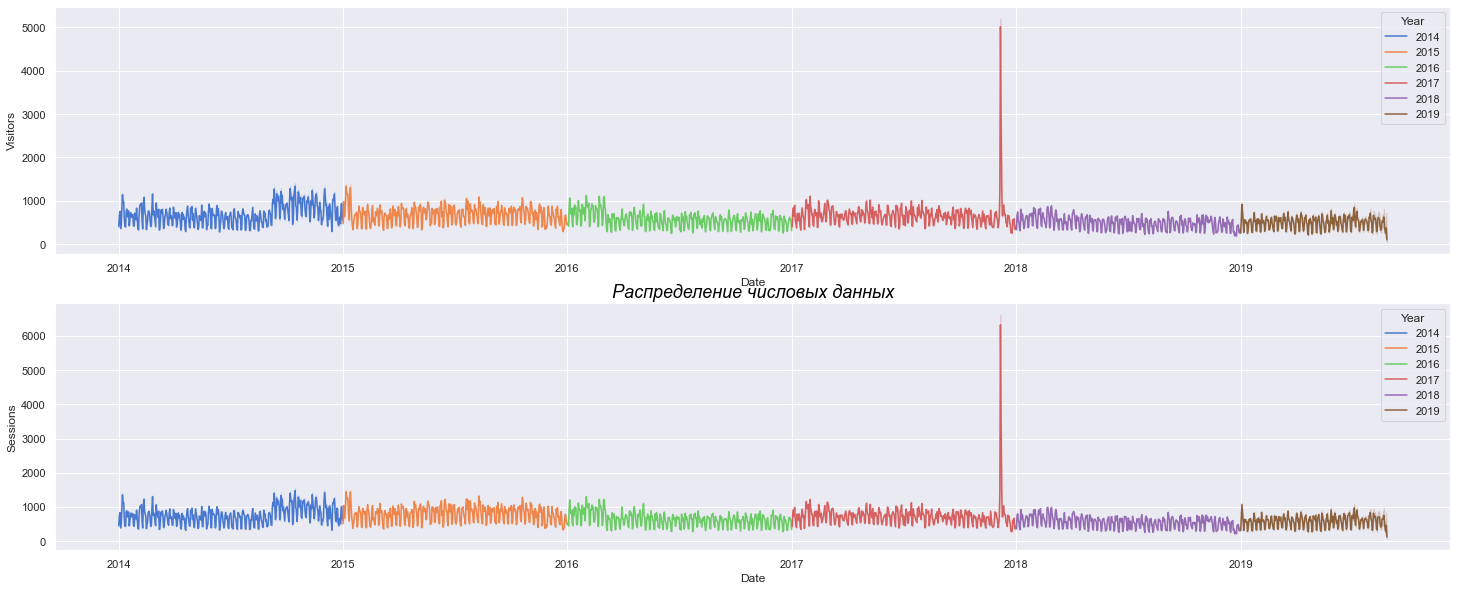

In [16]:
fig, axs = plt.subplots(nrows=2, figsize=(25, 10))
plt.title('Распределение числовых данных', color='black', fontsize=18, fontstyle='italic')
sns.lineplot(x='Date', y='Visitors', data=data, ax=axs[0], hue='Year', palette='muted')
sns.lineplot(x='Date', y='Sessions', data=data, ax=axs[1], hue='Year', palette='muted')
plt.show()

In [17]:
data[data.Visitors == data.Visitors.max()]

,Date,Device_Category,Browser,Visitors,Sessions,Bounce_Rate,Day,Day_of_year,Week,Month,Year
5445268,2017-12-06,mobile,Safari,34365,46124,40.9245,6,340,49,December,2017


Взглянем подробнее на 'проблемный' месяц

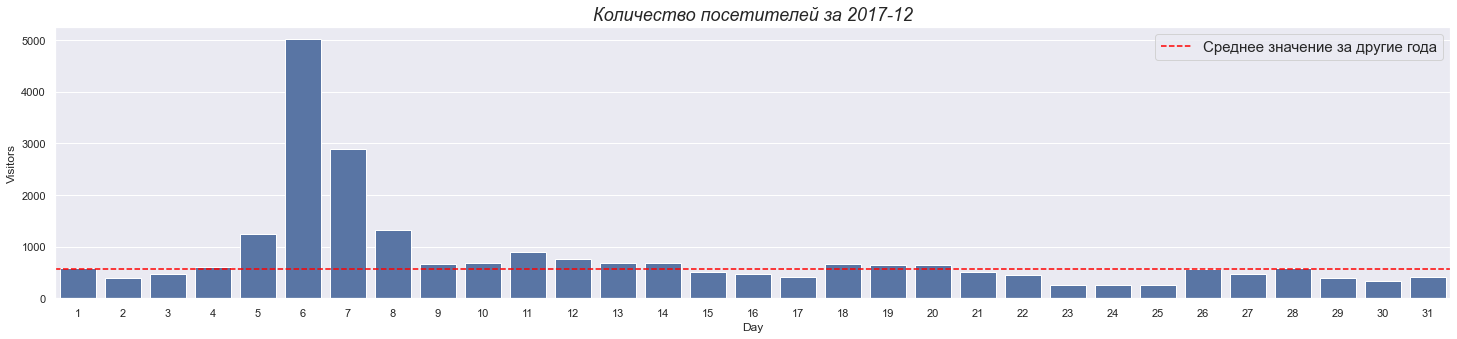

In [18]:
plt.figure(figsize=(25,5))
plt.title('Количество посетителей за 2017-12', fontsize=18, fontstyle='italic')
sns.barplot(data=data[(data.Year == 2017) & (data.Month == 'December')], x='Day', y='Visitors', ci=False, color='b')
plt.axhline(data[(data.Year != 2017) & (data.Month == 'December')].Visitors.mean(), color='red', linestyle='dashed', label='Среднее значение за другие года')
plt.legend(fontsize=15)
plt.show()

<b> Причиной такого всплеска посещаемости в период 2017-12-05 до 2017-12-08 были сильные пожары. Как можно судить по заголовам в новостях того дня <br>
    "California Fires Enter the Heart of Los Angeles", пожары добрались до самого города

Взглянем на браузеры пользователей

In [19]:
data.Browser.unique()

array(['Chrome', 'Firefox', 'Internet Explorer', 'Opera', 'Safari',
       'Android Browser', 'Safari (in-app)', 'Amazon Silk',
       'IE with Chrome Frame', 'BlackBerry', 'UC Browser', 'Opera Mini',
       'YaBrowser', 'Nintendo Browser', 'Dolfin', 'NetFront',
       'S40 Ovi Browser', 'Mozilla', 'Mozilla Compatible Agent',
       'Nokia Browser', 'BrowserNG', 'Maxthon', '(not set)', 'MRCHROME',
       'Playstation 3', 'PlayFreeBrowser', 'Phantom Browser', 'Iron',
       'Camino', 'BlackBerry9630', 'Netscape', 'SeaMonkey',
       'Nintendo 3DS Browser', 'Konqueror', 'pr-cy.ru Screenshot Bot',
       'Playstation Vita Browser', 'BlackBerry9550', 'samsung-GT-I9500',
       'Edge', 'Easy-Thumb', 'WeSEE_Bot:we_help_monitize_your_site',
       'Peeplo Screenshot Bot', 'Coc Coc', 'YE',
       'HggH PhantomJS Screenshoter', 'DDG-Android-3.0.12',
       'Phantom.js bot', 'Android Webview', 'YelpWebView',
       'Samsung Internet', 'AdobeAIR', 'UCWEB', 'Puffin', "'Mozilla",
       '"mozilla',

Можно сразу отметить браузеры данные с которых не стоит учитывать

In [20]:
bots = ['(not set)','pr-cy.ru Screenshot Bot','WeSEE_Bot:we_help_monitize_your_site',
        'Peeplo Screenshot Bot','HggH PhantomJS Screenshoter','Phantom.js bot','fuelbot']
bots_index = data[data.Browser.isin(bots)].index

In [21]:
data = data.drop(index=bots_index)

Теперь взглянем на распределение по типу девайсов используемых для посещения сайта

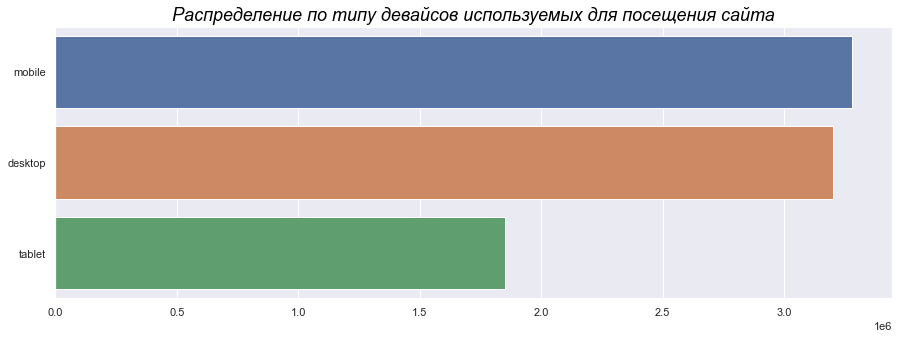

In [22]:
plt.figure(figsize=(15,5))
plt.title('Распределение по типу девайсов используемых для посещения сайта', color='black', fontsize=18, fontstyle='italic')
sns.barplot(x=data.Device_Category.value_counts().values, y=data.Device_Category.value_counts().index.to_list())
plt.show()

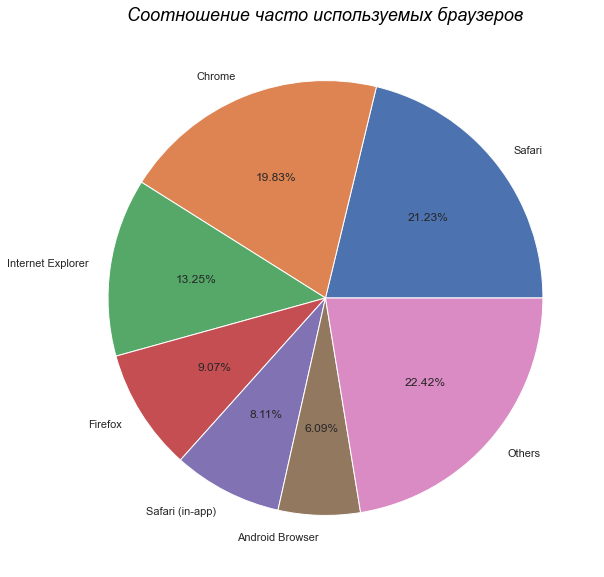

In [23]:
browser_visitors = np.append(data.Browser.value_counts().values[:6], data.Browser.value_counts().values[6:].sum())
browser_names = data.Browser.value_counts().index[:6].to_list()
browser_names.append('Others')                             
plt.figure(figsize=(10,10))
plt.title('Соотношение часто используемых браузеров', color='black', fontsize=18, fontstyle='italic')
plt.pie(x=browser_visitors, labels=browser_names, autopct='%1.2f%%', radius=1)
plt.show()

In [24]:
best_bunch = data.groupby(['Device_Category','Browser'], as_index=False).agg({'Visitors':'sum'}).sort_values(by='Visitors', ascending=False).reset_index()
best_bunch['Bundle'] = best_bunch.Device_Category + '_' + best_bunch.Browser

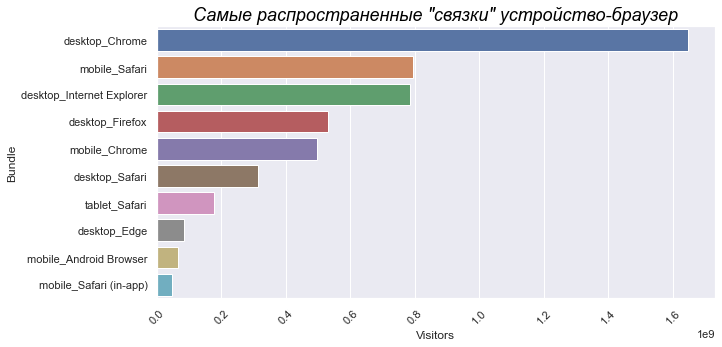

In [25]:
plt.figure(figsize=(10,5))
plt.title('Самые распространенные "связки" устройство-браузер', color='black', fontsize=18, fontstyle='italic')
sns.barplot(data=best_bunch.iloc[:10], y='Bundle', x='Visitors')
plt.xticks(rotation = 45)
plt.show()

Сгруппируем наши данные по дате, а также заменим выявленные выбросы

In [26]:
data_full = data.groupby(['Date','Year','Month','Week','Day'], as_index=False).agg({'Visitors':'sum'})
outliers_date = data_full[((data_full.Year == 2017) & (data_full.Month == 'December')) & data_full.Day.isin([5,6,7,8])].Date
mean_visitors = data_full[((data_full.Year != 2017) & (data_full.Month == 'December')) & data_full.Day.isin([5,6,7,8])].groupby(['Day'], as_index=False).agg({'Visitors':'mean'}).Visitors

data_full = data_full.replace(data_full[data_full.Date.isin(outliers_date)].Visitors.values, mean_visitors.values.astype(int))

Возьмем данные за полные года и снова проверим посмотрим на них после группировки

In [27]:
data_full = data_full[data_full.Year != 2019]
data_full['Day_of_Week'] = data_full.Date.dt.day_name()

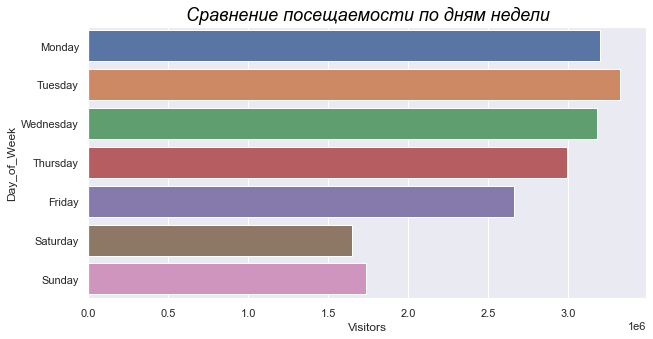

In [28]:
plt.figure(figsize=(10,5))
plt.title('Сравнение посещаемости по дням недели', color='black', fontsize=18, fontstyle='italic')
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.barplot(data=data_full, x='Visitors', y='Day_of_Week', order=order, ci=False)
plt.show()

Сразу можно увидеть недельную сезонность

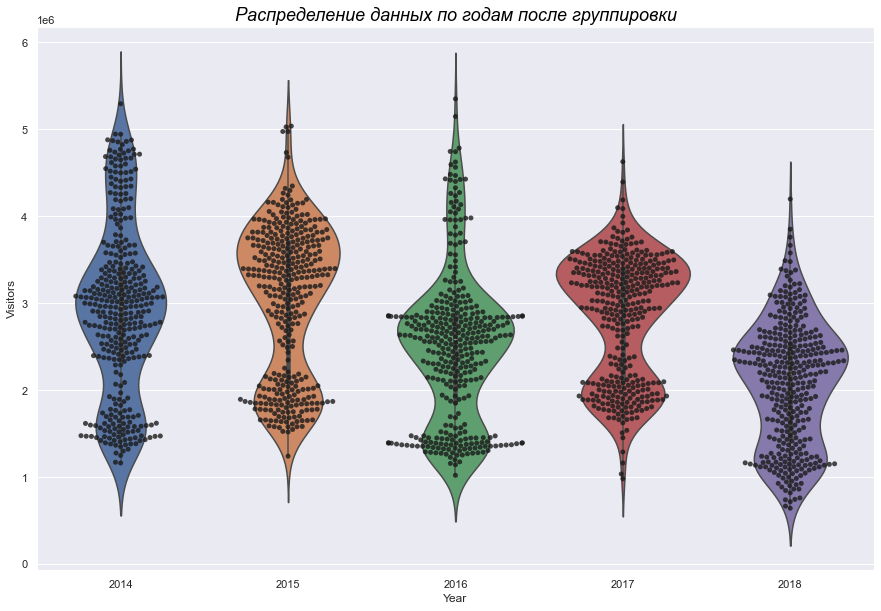

In [29]:
plt.figure(figsize=(15,10))
plt.title('Распределение данных по годам после группировки', color='black', fontsize=18, fontstyle='italic')
sns.violinplot(data=data_full, y='Visitors', x='Year')
sns.swarmplot(data=data_full, y='Visitors', x='Year', alpha=0.8, color='k')
plt.show()

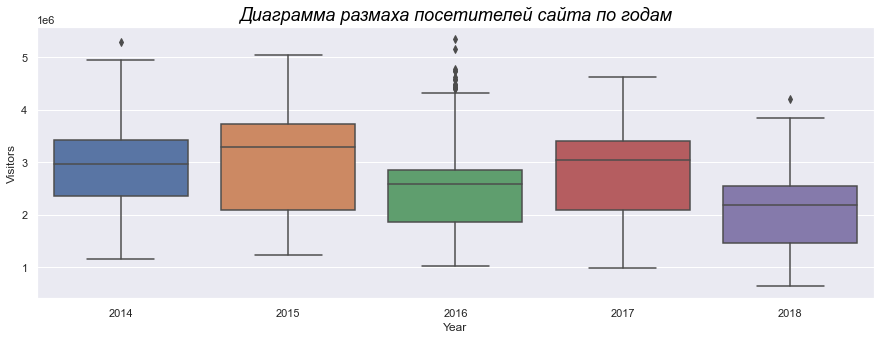

In [30]:
plt.figure(figsize=(15,5))
plt.title('Диаграмма размаха посетителей сайта по годам', color='black', fontsize=18, fontstyle='italic')
sns.boxplot(data=data_full, y='Visitors', x='Year')
plt.show()

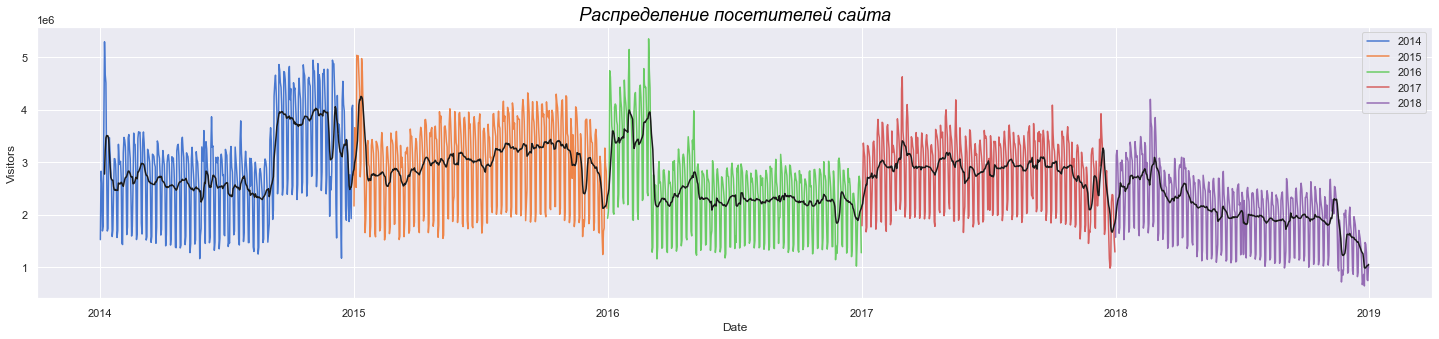

In [31]:
plt.figure(figsize=(25,5))
plt.title('Распределение посетителей сайта', color='black', fontsize=18, fontstyle='italic')
sns.lineplot(data=data_full, x='Date', y='Visitors', hue='Year', palette='muted')
sns.lineplot(x=data_full.Date, y=data_full.Visitors.rolling(7).mean(), color='k')
plt.show()

На графике можно увидеть довольно странные всплески посещаемости в 2015 - 2017 годах. Даже наблюдается некая цикличность. <br>
Поиск в интернете не дал информации чем мог быть вызван такой рост посещаемости. Из-за неизвестной природы таких всплесков, мы не будем их удалять 

# Проверим наши данные на нормальность распределения

1. Визуально попытаемся проверить данные на нормальность с помощью графика Quantile-Quantile Plot

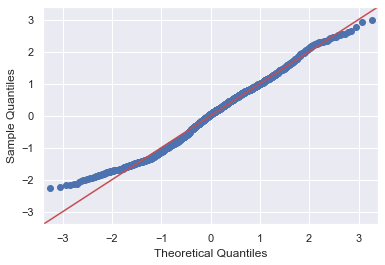

In [32]:
fig = sm.qqplot(data_full.Visitors.values, line='45', fit=True)
plt.show()

Точки на графике ложатся примерно на прямую диагональную линию, но имеют явные "хвосты", мы предполагаем, что набор данных не имеет нормальное распределение

<b> Нулевая гипотеза H0: данные имеют нормальное распределение

2. Проверка на нормальность распределения с помощью тестов Шапиро-Уилка и Колмогорова-Смирнова 

In [33]:
shapiro(data_full.Visitors)

ShapiroResult(statistic=0.9885720610618591, pvalue=7.846249344689582e-11)

P-значение меньше 0.05, мы отвергаем нулевую гипотезу теста Шапиро-Уилка

In [34]:
loc, scale = norm.fit(data_full.Visitors.values)
norm_dist = norm(loc=loc, scale=scale)

kstest(data_full.Visitors, norm_dist.cdf)

KstestResult(statistic=0.04395203596341751, pvalue=0.001672880260398128, statistic_location=1934894, statistic_sign=1)

P-значение меньше 0.05, мы отвергаем нулевую гипотезу теста Колмогорова-Смирнова

<b> Можно резюмировать, что наши данные не имеют нормальное распределение согласно проведенным тестам

# Проверим данные на наличие тренда

<b> Проверка разности средних уровней

Данные разбиваются на 2 части, каждая часть рассматривается как отдельная выборка, по каждой выборке рассчитывается среднее значение и проверяется гипотеза о равенстве средних <br>
Так как гипотеза о нормальности отклоняется, будем использовать непараметрический метод, такой как критерий Манна-Уитни

<b> Нулевая гипотеза H0: средние значение выборок равны 

In [35]:
data_full.Visitors.size // 2

913

In [36]:
part_1 = data_full.Visitors.iloc[:913]
part_2 = data_full.Visitors.iloc[913:]

In [37]:
mannwhitneyu(part_1, part_2)

MannwhitneyuResult(statistic=550018.0, pvalue=2.8420315887867335e-32)

P-значение меньше 0.05, мы отвергаем нулевую гипотезу теста Манна-Уитни о равенстве средних, то есть тренд присутствует

# Тройное экспоненциальное сглаживание. Модель Хольта-Винтерса.

Разделим данные на тренировочные и тестовые. В качестве тестовых будет выступать 30 дней.

In [38]:
train_visitors = data_full.Visitors.iloc[:1796]
test_visitors = data_full.Visitors.iloc[1796:]

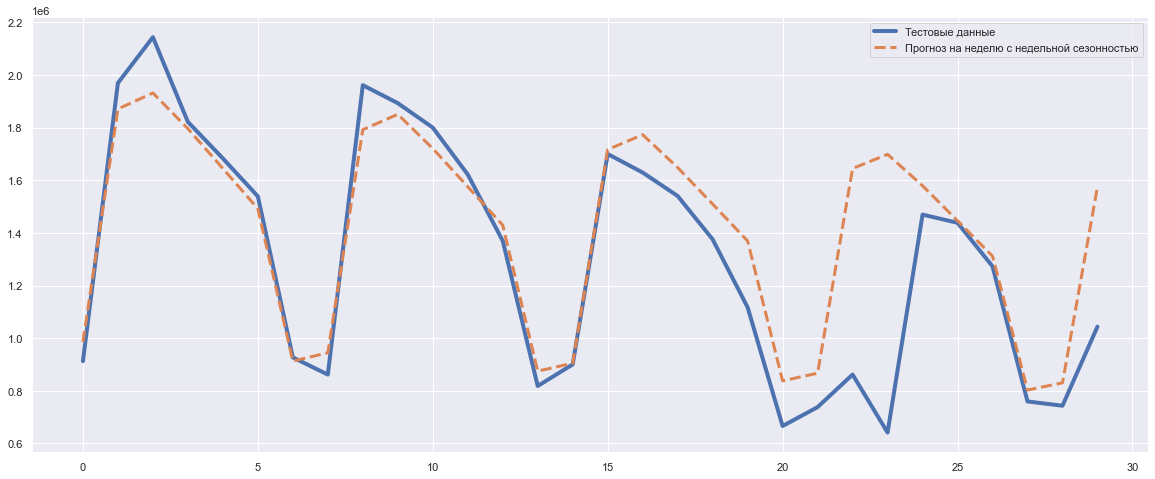

In [39]:
plt.figure(figsize=(20,8))
fitted_model_week = ExponentialSmoothing(train_visitors, trend = 'mul', seasonal = 'mul', seasonal_periods = 7, use_boxcox=False).fit()

test_predictions_week = fitted_model_week.forecast(30)

test_visitors.reset_index(drop=True).plot(legend = True, label = 'Тестовые данные', linewidth=4)
test_predictions_week.reset_index(drop=True).plot(legend = True, label = 'Прогноз на неделю c недельной сезонностью', linewidth=3, linestyle='--')

plt.show()

In [40]:
def score(y_true, y_pred):
    print(f'MAE score {round(mean_absolute_error(y_true, y_pred), 2)}')
    print(f'MAPE score {round(mean_absolute_percentage_error(y_true, y_pred), 2)}')
    print(f'R2 score {round(r2_score(y_true, y_pred), 2)}')

In [41]:
score(test_visitors, test_predictions_week)

MAE score 155481.19
MAPE score 0.17
R2 score 0.62


<b> Теперь попробуем с кросс-валидацией. Проверять будем также на месяце

In [42]:
def timeseriesCVscore(data):
    errors = []
    values = data.values
    tscv = TimeSeriesSplit(n_splits=5, test_size=30) 

    for train, test in tscv.split(values):
        fitted_model = ExponentialSmoothing(values[train], trend = 'add', seasonal = 'mul', seasonal_periods = 7).fit()
        predictions = fitted_model.forecast(len(test))
        actual = values[test]
        error = mean_absolute_error(actual, predictions)
        errors.append(error)

    return print(f' MAE score {round(np.mean(np.array(errors)), 2)}')

In [43]:
timeseriesCVscore(data_full.Visitors)

 MAE score 208582.69


# SARIMAX

Чтобы воспользоваться моделью SARIMA, необходимо убедиться, что наш времянной ряд является стационарным. <br>
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, <br>
а именно постоянство матожидания, постоянство дисперсии и независимость ковариационной функции от времени.

<b> Нулевая гипотеза H0: временной ряд является нестационарным

In [44]:
adf_test = adfuller(data_full.Visitors)

print(f'Статистика теста {adf_test[0]}')
print(f'P-значение {adf_test[1]}')

Статистика теста -2.152051932203275
P-значение 0.2241054881253446


P-значение больше 0.05, мы принимаем нулевую гипотезу теста Дики-Фуллера о нестационарности.

Избавимся от тренда

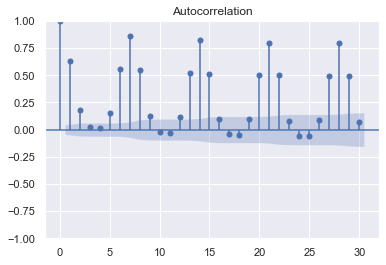

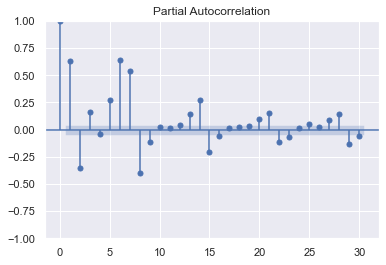

In [45]:
plot_acf(data_full.Visitors.values, lags=30)
plot_pacf(data_full.Visitors.values, method='ywm', lags=30)
plt.show()

Попробуем убрать нашу недельную сезонность

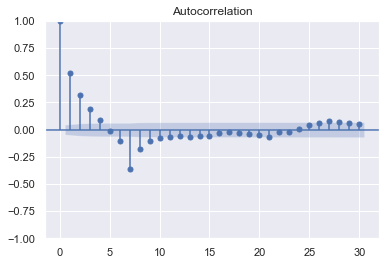

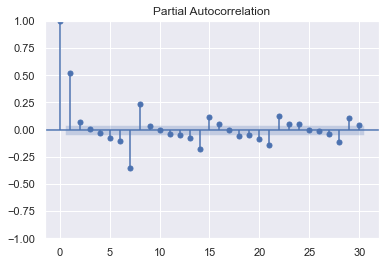

In [46]:
plot_acf(data_full.Visitors.diff(7).dropna(), lags=30)
plot_pacf(data_full.Visitors.diff(7).dropna(), method='ywm', lags=30)
plt.show()

In [63]:
adf_test_stationarity = adfuller(data_full.Visitors.diff(1).dropna())

print(f'Статистика теста {adf_test_stationarity[0]}')
print(f'P-значение {adf_test_stationarity[1]}')

Статистика теста -12.599943768338786
P-значение 1.7451222993358153e-23


In [48]:
data_full.index = data_full.Date

In [82]:
train_visitors_TST = data_full.Visitors.iloc[:1796]
test_visitors_TST = data_full.Visitors.iloc[1796:]

По средствам анализа графиков ACF и PACF, а также эмперическим путем были подобраны такие праметры p,d,q и P,D,Q,s

In [83]:
model=sm.tsa.statespace.SARIMAX(train_visitors_TST, order=(2, 1, 1), 
                                seasonal_order=(0, 1, 1, 7)).fit(disp=False)

In [686]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          Visitors   No. Observations:                 1796
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -25267.778
Date:                           Fri, 10 Mar 2023   AIC                          50545.557
Time:                                   11:32:28   BIC                          50573.001
Sample:                               01-01-2014   HQIC                         50555.691
                                    - 12-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4791      0.045     10.742      0.000       0.392       0.566
ar.L2          0.0406      0.038      1.079

<br>
Ljung–Box тест 

<b> Нулевая гипотеза H0: остатки стационарны </b> <br>

p-значение больше 0.05, мы не отклоняем нулевую гипотезу 

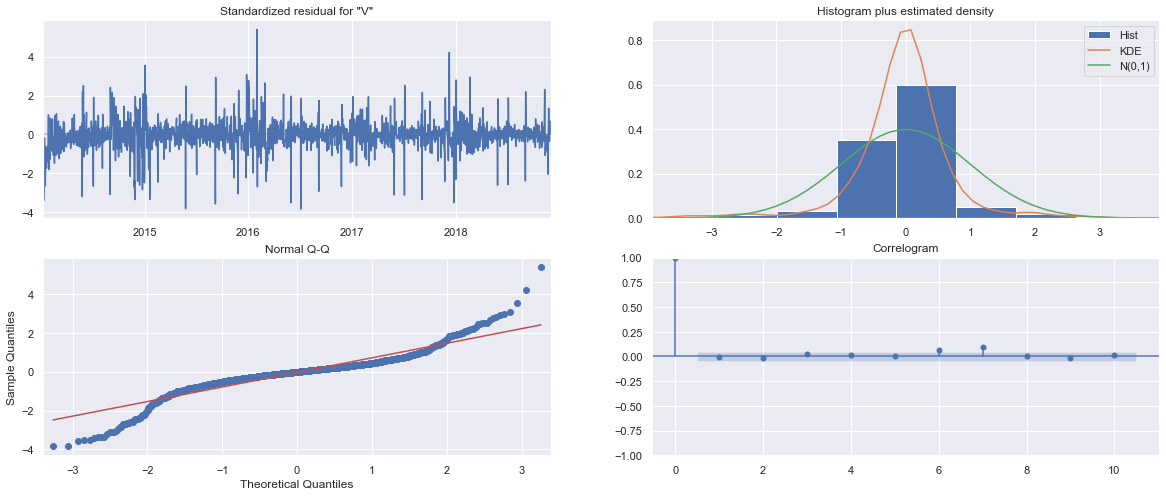

In [687]:
model.plot_diagnostics(figsize=(20,8))
plt.show()

Можно увидеть, что остатки распределенны <b> ненормально.

In [84]:
pred_SARIMAX = model.predict(start = test_visitors_TST.index[0], end = test_visitors_TST.index[29])

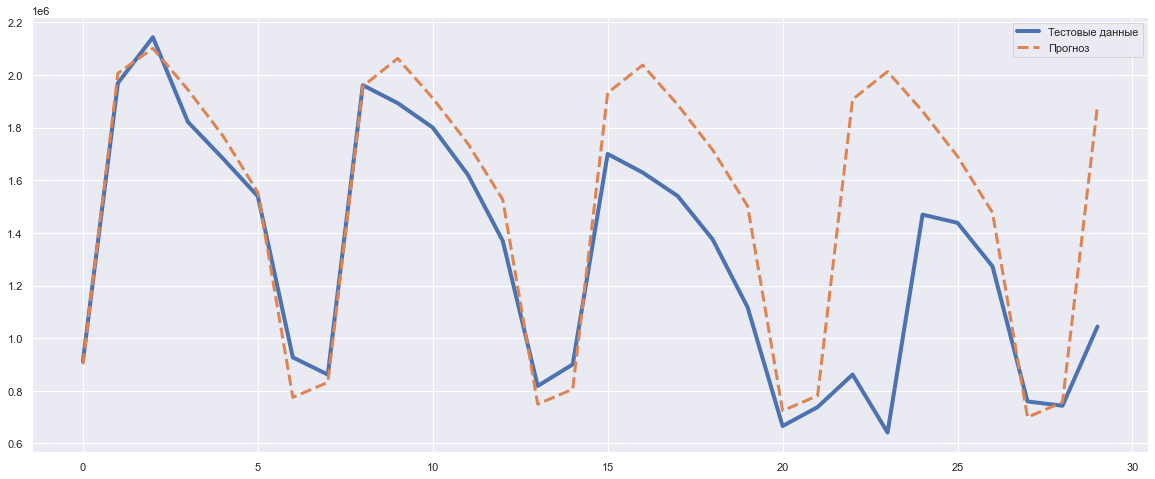

In [85]:
plt.figure(figsize=(20,8))

test_visitors_TST.reset_index(drop=True).plot(legend = True, label = 'Тестовые данные', linewidth=4)
pred_SARIMAX.reset_index(drop=True).plot(legend = True, label = 'Прогноз', linewidth=3, linestyle='--')
plt.show()

In [689]:
score(test_visitors_TST, pred_SARIMAX)

MAE score 240454.35
MAPE score 0.24
R2 score 0.23


Можно сказать, что модель обучилась плохо, а также не очень хорошо описывает наши данные. <br>
В качестве улучшения может помочь более детальный подбор параметров модели и возможное преобразование данных

# CatBoost

Попробуем предсказать количество наших пользователей с помощью библиотеки градиентного бустинга. <br>
Для этого мы добавим некоторое количество новых признаков

In [87]:
for i in range(1,8):
    data_full['lag-'+str(i)] = data_full.Visitors.shift(i)

data_full['lag+1'] = data_full.Visitors.shift(-1)
data_full['lag+6'] = data_full.Visitors.shift(-6)
data_full['lag+7'] = data_full.Visitors.shift(-7)

data_full['Roll_mean'] = data_full.Visitors.rolling(7).mean()
data_full['Diff'] = data_full.Visitors.diff(1)
data_full['Weekend'] = data_full.Day_of_Week.apply(lambda x: 1 if x in ['Saturday','Sunday'] else 0)

In [88]:
data_full.dropna(inplace=True)

In [89]:
X = data_full.drop(['Date','Week','Visitors','Day','Year'], axis=1)
y = data_full.Visitors

In [90]:
cat = CatBoostRegressor(cat_features=['Month','Day_of_Week'], verbose=False, depth=5, iterations=27, task_type='GPU', early_stopping_rounds=10)

In [91]:
cat.fit(X.iloc[:1788], y[:1788])

In [92]:
pred = cat.predict(X.iloc[1788:])

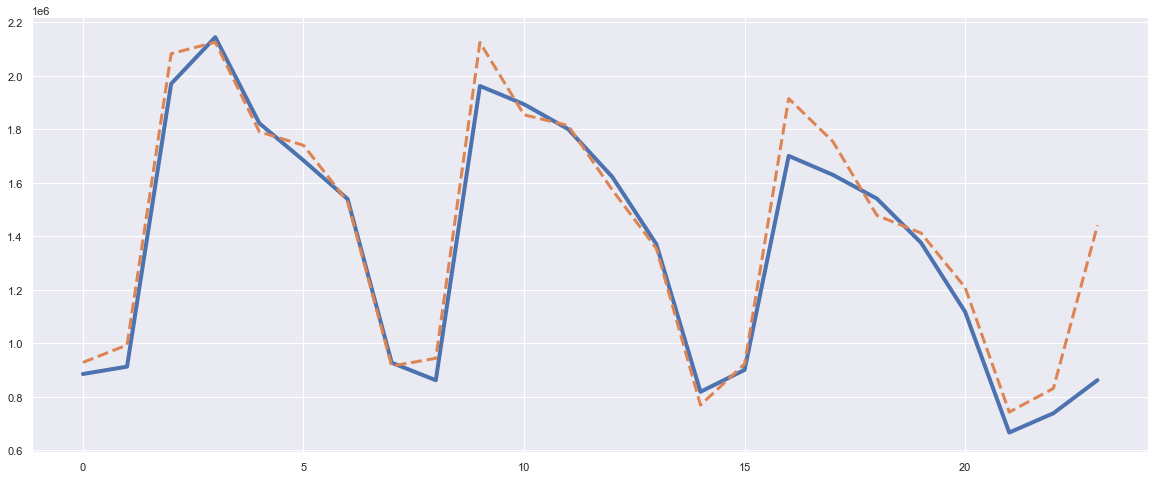

In [93]:
plt.figure(figsize=(20,8))
plt.plot(y.values[1788:], label = 'Тестовые данные', linewidth=4)
plt.plot(pred, label = 'Прогноз', linewidth=3, linestyle='--')
plt.show()

In [94]:
score(y[1788:], pred)

MAE score 86527.14
MAPE score 0.08
R2 score 0.9


А теперь с кросс-валидацией

In [127]:
data_full.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [129]:
def timeseriesCATscore(data):
    errors = []
    values = data.index
    tscv = TimeSeriesSplit(n_splits=5, test_size=30)
    cat = CatBoostRegressor(cat_features=['Month','Day_of_Week'], verbose=False, depth=5, iterations=27, task_type='GPU', early_stopping_rounds=10)

    for train, test in tscv.split(values):
        cat.fit(X[X.index.isin(train)], y[y.index.isin(train)])
        predictions = cat.predict(X[X.index.isin(test)])
        actual = y[y.index.isin(test)].values
        error = mean_absolute_error(actual, predictions)
        errors.append(error)

    return print(f' MAE score {round(np.mean(np.array(errors)), 2)}')

In [130]:
timeseriesCATscore(data_full)

 MAE score 109930.31


Можно подвести итог, что с нашими данными лучше всего справился градиентный бустинг.

Для возможного улучшения наших предсказаний можно было бы попробовать воспользоваться <br>
моделью "Prophet" от Facebook  